- **MODELISATION :** 


1) Chargement et transformation des données
2) Modélisation
3) Résultats de la modélisation
    - RandomForestClassifier
    - Regression Logistique
    - XGBoost Classifier
4) Prédiction du meilleur modèle
5) Features Importances
6) Conclusion

In [1]:
#!pip3 install mlflow 
#!pip3 install evidently
# 
!pip3 install xgboost




In [2]:
!pip3 install --upgrade pip




In [3]:
!pip3 install --upgrade nbformat


In [4]:
!pip3 install lightgbm

In [5]:
!pip3 install --upgrade mlflow


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, fbeta_score, make_scorer, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import GridSearchCV

from sklearn.metrics.pairwise import cosine_similarity 

import xgboost as xgb
from xgboost import XGBClassifier

import lightgbm as lgb
from lightgbm import LGBMClassifier

from sklearn.ensemble import RandomForestClassifier


from sklearn.linear_model import LogisticRegression

from sklearn.metrics import ConfusionMatrixDisplay


from evidently.report import Report
from evidently.metric_preset import ClassificationPreset
from evidently.metric_preset import DataDriftPreset
from evidently import ColumnMapping

import mlflow
from mlflow.models.signature import infer_signature
import shap
import mlflow.sklearn


from mlflow import evaluate

import joblib

In [7]:
mlflow.set_tracking_uri("file:///D:/Projet/P07/P07_Implementez_outils_scoring/p7-ml/.mlruns")  
mlflow.set_experiment("Credit_Scoring_Test") 

2025/06/10 21:05:00 INFO mlflow.tracking.fluent: Experiment with name 'Credit_Scoring_Test' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///D:/Projet/P07/P07_Implementez_outils_scoring/p7-ml/.mlruns/543179128818484245', creation_time=1749582300382, experiment_id='543179128818484245', last_update_time=1749582300382, lifecycle_stage='active', name='Credit_Scoring_Test', tags={}>

<div style="background-color:#934bd6; padding: 10px">
<h2>Chargement des données</h2>
</div>

Dans cette section, nous avons les étapes suivantes :

- Chargement des données
- Traitement des valeurs manquantes
- Définition des variables catégorielles et numériques

In [8]:
def score_metier(tp, fp, fn, tn, penalty_fn=2):
    total = tp + fp + fn + tn
    if total == 0:
        return np.nan
    score = (fp + penalty_fn * fn) / total
    return score * 100 


In [9]:
def seuil_optimal_metier_contrainte(model, X_test, y_test, penalty_fn=2, pas=0.01, min_taux_accord=25):
    best_thresh = None
    best_score = np.inf
    best_stats = None
    for t in np.arange(0.05, 0.9, pas):
        y_proba = model.predict_proba(X_test)[:, 1]
        y_pred = (y_proba >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        total = tp + fp + fn + tn
        score = (fp + penalty_fn * fn) / total * 100 if total else np.nan
        taux_accord = (tp + fp) / total * 100 if total else 0
        if taux_accord >= min_taux_accord and score < best_score:
            best_score = score
            best_thresh = t
            best_stats = (tn, fp, fn, tp, taux_accord)
    return best_thresh, best_score, best_stats

In [10]:
df = pd.read_csv("D:\\Projet\\P07\\P07_Implementez_outils_scoring\\p7-ml\\fichier_ml\\app_train_sample_clean.csv")
df.head(5)

,ID_CLIENT,CIBLE,TYPE_CONTRAT,GENRE,PROPRIETAIRE_VOITURE,PROPRIETAIRE_BIEN_IMMO,NBR_ENFANTS,REVENU_TOTAL,MONTANT_CREDIT,MONTANT_ANNUITE,...,ACCOMPAGNANT_DEMANDE,AGE,ANNEES_EMPLOI,SCORE_CONTACT,RATIO_ENFANTS_FAMILLE,DUREE_CREDIT_MOIS,DELAI_TRAITEMENT_DOSSIER,TRAITEMENT_DOSSIER_GROUPE,TRAITEMENT_DOSSIER_SIMPLIFIE,EMPLOI_TYPE
0,101392,0,Cash loans,F,Y,Y,0,81000.0,573628.5,24435.0,...,Unaccompanied,54.3,2,1,0.000000,23.0,2343.0,120j+,Long,Expérience Faible
1,435135,0,Cash loans,F,N,N,0,112500.0,298512.0,19948.5,...,Unaccompanied,25.2,2,2,0.000000,15.0,87.0,60-120j,Long,Expérience Faible
2,341153,1,Cash loans,F,N,Y,0,90000.0,1006920.0,42790.5,...,Unaccompanied,44.0,0,1,0.000000,24.0,3806.0,120j+,Long,Sans emploi
3,401501,0,Cash loans,M,Y,Y,1,180000.0,364896.0,31347.0,...,Unaccompanied,37.6,14,1,0.333333,12.0,1751.0,120j+,Long,Expérience Moyenne
4,341989,0,Revolving loans,F,N,Y,1,135000.0,405000.0,20250.0,...,Unaccompanied,31.5,4,1,0.333333,20.0,1782.0,120j+,Long,Expérience Faible


In [11]:
df['EMPLOI_TYPE'].unique()

array(['Expérience Faible', 'Sans emploi', 'Expérience Moyenne',
       'Retraité', 'Expérience Longue'], dtype=object)

In [12]:
df.dtypes

ID_CLIENT                         int64
CIBLE                             int64
TYPE_CONTRAT                     object
GENRE                            object
PROPRIETAIRE_VOITURE             object
PROPRIETAIRE_BIEN_IMMO           object
NBR_ENFANTS                       int64
REVENU_TOTAL                    float64
MONTANT_CREDIT                  float64
MONTANT_ANNUITE                 float64
MONTANT_BIENS                   float64
TYPE_REVENUS                     object
NIVEAU_EDUCATION                 object
STATUT_FAMILIAL                  object
TYPE_LOGEMENT                    object
JOURS_ENREGISTREMENT            float64
JOURS_ID_PUBLICATION              int64
FLAG_MOBILE                       int64
FLAG_TELEPHONE_PRO                int64
FLAG_TELEPHONE_TRAVAIL            int64
FLAG_TELEPHONE                    int64
FLAG_EMAIL                        int64
NBR_MEMBRES_FAMILLE             float64
SOURCE_EXTERNE_2                float64
JOURS_DERNIER_CHANGEMENT_TEL    float64


**Préparation des données**

In [13]:
X = df.drop(columns=["CIBLE", "ID_CLIENT"])
y = df["CIBLE"]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [15]:
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include=np.number).columns.tolist()

In [16]:
cat_cols

['TYPE_CONTRAT',
 'GENRE',
 'PROPRIETAIRE_VOITURE',
 'PROPRIETAIRE_BIEN_IMMO',
 'TYPE_REVENUS',
 'NIVEAU_EDUCATION',
 'STATUT_FAMILIAL',
 'TYPE_LOGEMENT',
 'TYPE_ENTREPRISE',
 'JOUR_DEMANDE',
 'ACCOMPAGNANT_DEMANDE',
 'TRAITEMENT_DOSSIER_GROUPE',
 'TRAITEMENT_DOSSIER_SIMPLIFIE',
 'EMPLOI_TYPE']

In [17]:
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])


**Définition des modèles**

In [18]:
models = {
    "LogisticRegression": {
        "model": LogisticRegression(class_weight="balanced", solver="liblinear", random_state=42),
        "params": {
            "C": [0.001, 0.01, 0.1, 1, 10]
        }
    },
    "RandomForest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [100, 200, 300],
            "max_depth": [5, 10, 15]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(tree_method='hist', eval_metric='logloss', random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [5, 7, 9],
            "subsample": [0.8, 1.0]
        }
    },
    "LightGBM": {
        "model": lgb.LGBMClassifier(random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "learning_rate": [0.05, 0.1],
            "num_leaves": [31, 50]
        }
    }
}


**Entrainement et évaluation**

In [19]:
results = {}
best_models = {}
mlflow.set_experiment("Credit_Scoring")

2025/06/10 21:05:01 INFO mlflow.tracking.fluent: Experiment with name 'Credit_Scoring' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///D:/Projet/P07/P07_Implementez_outils_scoring/p7-ml/.mlruns/115618283817832140', creation_time=1749582301529, experiment_id='115618283817832140', last_update_time=1749582301529, lifecycle_stage='active', name='Credit_Scoring', tags={}>

In [20]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
f2_scorer = make_scorer(fbeta_score, beta=2)

2025/06/10 21:07:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/06/10 21:09:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/06/10 21:10:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[LightGBM] [Info] Number of positive: 8146, number of negative: 8146
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19153
[LightGBM] [Info] Number of data points in the train set: 16292, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


2025/06/10 21:12:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


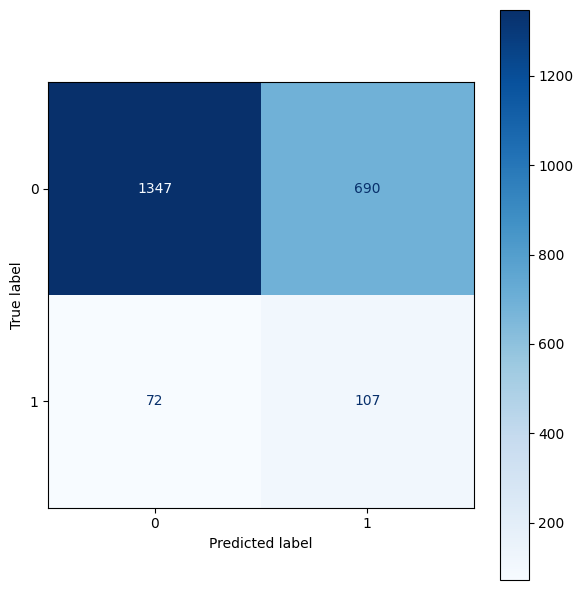

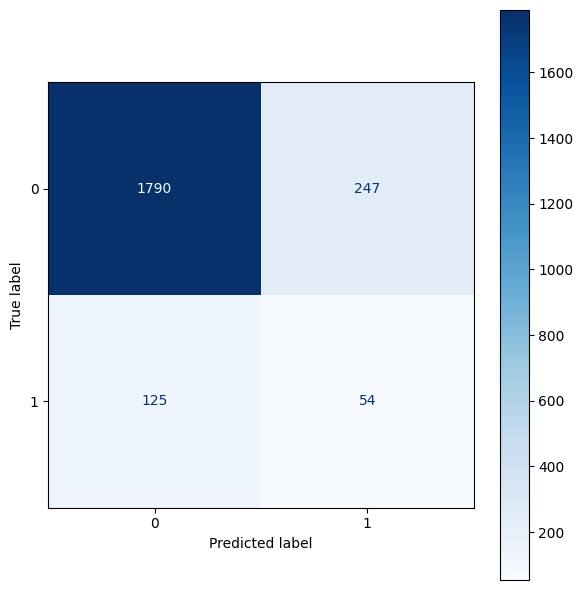

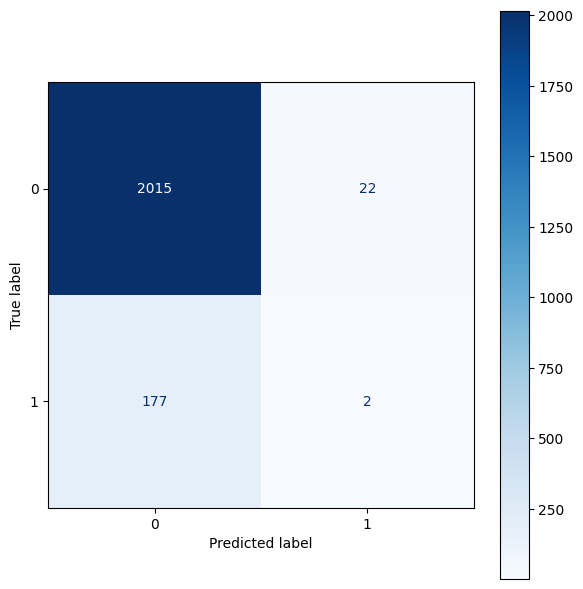

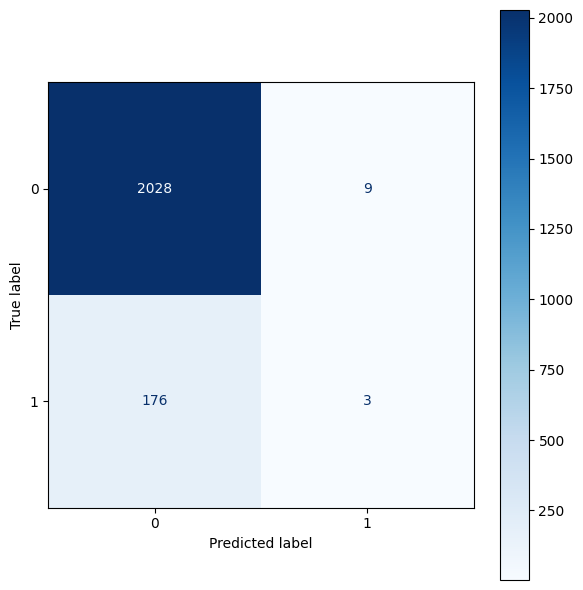

In [22]:
for name, cfg in models.items():
    pipe = ImbPipeline([
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("model", cfg["model"])
    ])

    search = GridSearchCV(
        pipe,
        {"model__" + key: val for key, val in cfg["params"].items()},
        cv=cv, scoring=f2_scorer, n_jobs=-1
    )
    search.fit(X_train, y_train)

    best_model = search.best_estimator_
    y_proba = best_model.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_proba)
    y_pred = (y_proba >= 0.2).astype(int)
    f2 = fbeta_score(y_test, y_pred, beta=2)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    acc = accuracy_score(y_test, y_pred) 

    results[name] = {
        "Best Params": search.best_params_,
        "AUC": auc_score,
        "F2 Score": f2,
        
        "Accuracy": acc
    }
    best_models[name] = best_model

    with mlflow.start_run(run_name=f"Best_{name}") as run:
    # 🔹 1. Log des hyper-paramètres
        mlflow.log_params(search.best_params_)

        # 🔹 2. Log des métriques clé
        mlflow.log_metric("AUC", auc_score)
        mlflow.log_metric("F2", f2),
        
        mlflow.log_metric("Accuracy", acc)

        # 🔹 3. Sauvegarde du modèle
        mlflow.sklearn.log_model(best_model, f"best_model_{name}")

        fig, ax = plt.subplots(figsize=(6, 6))
        ConfusionMatrixDisplay.from_estimator(
            best_model, X_test, y_test, ax=ax, cmap="Blues"
        )
        plt.tight_layout()
        fig.savefig("confusion_matrix.png")
        mlflow.log_artifact("confusion_matrix.png")

        

        
        mlflow.log_artifact("030_P07_Test_modelisation.ipynb")

In [22]:
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(C=1.0, solver="liblinear", max_iter=100))
])


In [ ]:


with mlflow.start_run(run_name="LogReg_Pipeline"):
    
    pipeline.fit(X_train, y_train)

    # prédictions & métriques
    probs = pipeline.predict_proba(X_test)[:,1]
    preds = pipeline.predict(X_test)
    acc     = accuracy_score(y_test, preds)
    roc_auc = roc_auc_score(y_test, probs)
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("roc_auc", roc_auc)

    

    
    input_example = X_train.head(3)
    
    signature = infer_signature(input_example, pipeline.predict(input_example))

    
    mlflow.sklearn.log_model(
        sk_model=pipeline,
        artifact_path="pipeline_model",
        signature=signature,
        input_example=input_example
    )


In [ ]:
joblib.dump(preprocessor, "preprocessor.joblib")

**Choix du meilleur modèle**

In [ ]:
results_df = pd.DataFrame(results).T
print("\nRésultats :")
print(results_df)

In [ ]:
best_model_name = results_df["F2 Score"].idxmax()
best_model = best_models[best_model_name]
print(f"\n📌 Meilleur Modèle : {best_model_name}")
print(results_df.loc[best_model_name])

In [ ]:
joblib.dump(best_models, "best_models.joblib")


# **Test Financier et seuil métier**

***Seuil Optimal avec LogisticRegression***

In [ ]:
best_thresh_logreg, best_score_logreg, stats = seuil_optimal_metier_contrainte(
    best_models['LogisticRegression'],
    X_test,
    y_test,
    penalty_fn=2,
    pas=0.01,
    min_taux_accord=25
)
tn, fp, fn, tp, taux_accord = stats
print(f"✅ Seuil optimal : {round(best_thresh_logreg, 2)} | Score métier : {round(best_score_logreg, 2)} % | Taux d’accord : {round(taux_accord, 2)} %")
print(f"Accordés (TP+FP) : {tp+fp}, Refusés (TN+FN) : {tn+fn}, TP : {tp}, FP : {fp}, TN : {tn}, FN : {fn}")

In [ ]:
seuils = np.arange(0.05, 0.91, 0.01)
scores_metier = []
taux_accords = []

penalty_fn = 2  # à adapter selon les règles métier

for t in seuils:
    y_proba = best_models['LogisticRegression'].predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    total = tp + fp + fn + tn
    score_metier = (fp + penalty_fn * fn) / total * 100 if total else np.nan
    taux_accord = (tp + fp) / total * 100 if total else 0
    scores_metier.append(score_metier)
    taux_accords.append(taux_accord)

# Seuil optimal
seuil_optimal = 0.55
idx_opt = np.abs(seuils - seuil_optimal).argmin()
score_opt = scores_metier[idx_opt]
accord_opt = taux_accords[idx_opt]

plt.figure(figsize=(12, 7))
plt.plot(seuils, scores_metier, label='Score métier (%)', color='#C0392B', linewidth=2.5)
plt.plot(seuils, taux_accords, label='Taux d’accord (%)', color='#2874A6', linewidth=2.5)

plt.axvline(x=seuil_optimal, color='green', linestyle='--', linewidth=2, label=f'Seuil optimal = {seuil_optimal:.2f}')
plt.scatter([seuil_optimal], [score_opt], color='#C0392B', s=120, zorder=5)
plt.scatter([seuil_optimal], [accord_opt], color='#2874A6', s=120, zorder=5)

plt.annotate(f'Score métier\n{score_opt:.2f} %', 
             xy=(seuil_optimal, score_opt), 
             xytext=(seuil_optimal+0.05, score_opt+15),
             arrowprops=dict(facecolor='#C0392B', shrink=0.07, width=2, headwidth=10),
             fontsize=13, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="#C0392B", lw=2))

plt.annotate(f'Taux d’accord\n{accord_opt:.2f} %',
             xy=(seuil_optimal, accord_opt),
             xytext=(seuil_optimal-0.30, accord_opt-5),
             arrowprops=dict(facecolor='#2874A6', shrink=0.07, width=2, headwidth=10),
             fontsize=13, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="#2874A6", lw=2))

plt.title("Évolution du score métier et du taux d’accord selon le seuil", fontsize=17, weight='bold')
plt.xlabel("Seuil de décision", fontsize=15)
plt.ylabel("Pourcentage (%)", fontsize=15)
plt.legend(fontsize=14, frameon=True, fancybox=True, shadow=True)
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.ylim(0, 105)
plt.xlim(seuils.min(), seuils.max())
plt.tight_layout()
plt.show()

In [ ]:
joblib.dump(best_thresh_logreg, "best_thresh_logreg.joblib")


Ici on a un très bon score métier car : 

- Refus de peu de bons clients (baisse des FP)
- Repère beaucoup de mauvais payeurs (hausse des TP)

# **SHAP**

In [ ]:
best_model_logreg = best_models['LogisticRegression']

joblib.dump(best_model_logreg, "model_logistic_regression.joblib")

In [32]:
pipeline = joblib.load("model_logistic_regression.joblib")
preprocessor = pipeline.named_steps['preprocessor']
model = pipeline.named_steps['model']

In [33]:
X_train_t = preprocessor.transform(X_train)
feature_names = preprocessor.get_feature_names_out()

In [34]:
explainer_logreg = shap.LinearExplainer(
    best_model_logreg.named_steps["model"],
    X_train_t,
    feature_names=preprocessor.get_feature_names_out()
)


shap_values = explainer_logreg(X_train_t)

In [ ]:
shap.summary_plot(
    shap_values, 
    X_train_t, 
    feature_names=feature_names, 
    plot_type="bar",
    max_display=10)

In [ ]:
joblib.dump(explainer_logreg, "explainer_logreg.joblib")

In [37]:
feature_names = best_model_logreg.named_steps['preprocessor'].get_feature_names_out()

In [ ]:
joblib.dump(feature_names, "feature_names.joblib")

In [39]:
X_test_eval = X_test.copy()

In [40]:
X_test_eval['ID_CLIENT'] = df.loc[X_test.index, 'ID_CLIENT'].values

In [ ]:
X_test_eval

In [ ]:
X_test_eval_display = X_test_eval.copy()
X_test_eval_display["PROBABILITE"] = best_model_logreg.predict_proba(X_test)[:, 1]
X_test_eval_display["PREDICTION"] = (X_test_eval_display["PROBABILITE"] >= best_thresh_logreg).astype(int)
X_test_eval_display["DECISION"] = X_test_eval_display["PREDICTION"].map({1: "REFUSÉ 🚫", 0: "ACCORDÉ 🥳"})

colonnes_a_afficher = ["ID_CLIENT", "AGE", "GENRE","PROPRIETAIRE_BIEN_IMMO", "NBR_ENFANTS", "REVENU_TOTAL","TYPE_CONTRAT","MONTANT_CREDIT","DUREE_CREDIT_MOIS",	"MONTANT_ANNUITE",	"TYPE_REVENUS",'SOURCE_EXTERNE_2',
 'TYPE_ENTREPRISE','HEURE_DEMANDE','JOUR_DEMANDE',
 "PREDICTION", "DECISION", "PROBABILITE", 'EMPLOI_TYPE']
X_test_eval_display[colonnes_a_afficher]


In [ ]:
X_test_eval.columns.tolist()

In [ ]:
id_client = 111292

# Recherche client dans X_test_eval
data_client = X_test_eval[X_test_eval['ID_CLIENT'] == id_client]

if data_client.empty:
    print(f"❌ L'ID client {id_client} n'est pas trouvé dans X_test_eval.")
else:
    idx_X_test = data_client.index[0]  # position dans X_test_eval
    true_index = X_test_eval.loc[idx_X_test, :].name  # index réel dans X_test

    model_used = best_model_logreg
    explainer_used = explainer_logreg
    threshold_used = best_thresh_logreg

    # ✅ Attention : on utilise .loc ici
    proba = model_used.predict_proba(X_test.loc[[true_index]])[:, 1][0]
    prediction = int(proba >= threshold_used)
    decision = "Refusé" if prediction == 1 else "Accordé"

    print(f"\n🔎 Client ID : {id_client}")
    print(f"✅ Décision Crédit : {decision}")
    print(f"🎯 Probabilité de défaut : {proba:.2f}")


In [45]:
# Tout simplement j'ai crée une dataframe qui détient toutes les données, j'ai séparé les features et les index en 2 dataframes distinctes. 
# Ensuite avec un système de loc j'ai fais correspondre les ID CLIENT avec les index de la dataframe contenants les features importances, 
# et de cette manières en récupérant l'échantillon de données, j'arrive à faire correspondre l'explainer avec les prédictions et infos clients. 

In [ ]:
shap.initjs()

# Transformation du client avec .loc pour éviter l'erreur d'index
X_client = model_used.named_steps['preprocessor'].transform(X_test.loc[[idx_X_test]])

# SHAP values
shap_values = explainer_used(X_client)

# Waterfall plot
shap.plots.waterfall(shap_values[0], max_display=10)


Visualisons maintenant avec un groupe de clients similaires

# **Evidently : Rapport de performance et de drift**




***Permet d'intégrer un rapport automatique de:*** 

     - Qualité des prédictions
     - Dérive de données (si comparaison avec des données futures)
     - Distributions des variables

In [47]:
# Ajout des colonnes nécessaires à Evidently
X_test_eval["CIBLE_Réelle"] = y_test.values  # la vraie cible
X_test_eval["Prédiction_LogReg"] = best_model_logreg.predict(X_test)  # prédictions


In [ ]:
column_mapping = ColumnMapping()
column_mapping.target = "CIBLE_Réelle"
column_mapping.prediction = "Prédiction_LogReg"


report = Report(metrics=[
    ClassificationPreset(),
    DataDriftPreset()
])

# Lancement de l’analyse
report.run(reference_data=X_test_eval, current_data=X_test_eval, column_mapping=column_mapping)



In [ ]:

report.save_html("rapport_evidently.html")
print("✅ Rapport Evidently généré et sauvegardé : rapport_evidently.html")

# Affichage inline (facultatif en local)
report.show(mode="inline")


# **Export de la dataframe**

In [ ]:
joblib.dump(X_test_eval, "X_test_eval.joblib")
print("✅ Écrasé dans /mnt/data")

In [ ]:
X_test_eval

In [52]:
X_test_eval.to_csv("X_test_eval.csv", index=False)


In [ ]:
print("🗂️ Colonnes X_test_eval:", X_test_eval.columns.tolist())
print("🔢 Quelques ID_CLIENT:", X_test_eval["ID_CLIENT"].head(5).tolist())


In [ ]:
with mlflow.start_run(run_name="LogReg_With_Evaluation"):
    pipeline.fit(X_train, y_train)

   
    mlflow.sklearn.log_model(pipeline, "pipeline_model")

    
    model_uri = mlflow.get_artifact_uri("pipeline_model")


loaded_model = mlflow.pyfunc.load_model(model_uri)

X_eval = X_test
y_eval = y_test

eval_data = X_eval.copy()
eval_data["label"] = y_eval

eval_result = mlflow.evaluate(
    model=loaded_model,
    data=eval_data,
    targets="label",
    model_type="classifier",
    evaluators=["default"]
)

In [55]:
#Trouver la ligne de commande pour lancer mlflow run pour lancer l'interface Mlflow

In [56]:
#Ainsi que le positionnement du client par rapport aux autres clients 
#3EME PAGE AVEC : 
# LE CLIENT AVEC UNE LISTE DEROULANTE AVEC LA LISTE DES VARIABLES 
# ET AFFICHER LE BOXPLOT SUR TOUT LE DATASET ET POSITIONNER LE CLIENT ADROITE OU A GAUCHE SUR LA DISTRIBUTION DES SALAIRES par exemple (classe positive : classe negative)
#2EME GRAPHIQUE POUR LA MEME VARIABLE LA DISTRIBUTION DE LA VARIABLE SELON LES CLASSES barplot du nombre de clients dans chaque classe. 

#Un graphique d’analyse bi-variée entre les deux features sélectionnées, avec un dégradé de couleur selon le score des clients, et le positionnement du client

#Screen des commit sur github a mettre dans pptx

#Test unitaire à faire (qqes lignes de codes : prendre API ou fonction il faut la tester, (pytest))

#Github action : manière d'automatiser les choses 
